In [38]:
"""
전반적인 코드는 깃허브 소스코드를 사용하였으며 버전에 따른 에러 및 스파게티코드 위주로 수정을 진행하였고, 
그래프를 나타내기 위해 코드를 추가하였습니다.
이번 레포트의 목표는 LSTM을 이해하고 외국인뿐만아니라 한국인 데이터를 크롤링하여 
영문 한국인 이름 데이터를 학습시켰을 때는 어떤 결과가 나오는지 알아봤습니다 . 
"""

'\n전반적인 코드는 깃허브 소스코드를 사용하였으며 버전에 따른 에러 및 스파게티코드 위주로 수정을 진행하였고, \n그래프를 나타내기 위해 코드를 추가하였습니다.\n이번 레포트의 목표는 LSTM을 이해하고 외국인뿐만아니라 한국인 데이터를 크롤링하여 \n영문 한국인 이름 데이터를 학습시켰을 때는 어떤 결과가 나오는지 알아봤습니다 . \n'

In [39]:
#1.데이터셋 소개

In [40]:
import pandas as pd
"""
data_name폴더 생성 후 폴더안에 train 및 validation 데이터 셋 저장
"""
train_df = pd.read_csv('data_name/train_dataset.csv')
val_df = pd.read_csv('data_name/val_dataset.csv')

In [41]:
# #분석에 불필요한 Unknown제거
# index=train_df[train_df['origin']=='Unknown'].index
# train_df=train_df.drop(index)
# index_val=val_df[val_df['origin']=='Unknown'].index
# val_df=val_df.drop(index_val)

In [42]:
#train_df.to_csv("D:\\Anaconda\\report\\data_name\\train_dataset2.csv",index=False)

In [43]:
print(len(train_df), len(val_df))
#train_df.tail()
#train_df.groupby('sex').babyname.count()
train_df.groupby('origin').babyname.count()

33953 3878


origin
African              95
American            666
Arabic              802
Aramaic             131
Armenian              2
Australian            3
Babylonian           13
Basque                8
British            4205
Cambodian             2
Celtic              113
Chinese              19
Czech                34
Danish               66
Dutch                16
Egyptian             13
French             1311
Gaelic              269
German             2354
Ghanaian             39
Greek              3314
Hawaiian            123
Hebrew             3188
Hungarian            65
Indian              262
Irish              1133
Italian             371
Japanese            125
Korea               344
Latin              3969
Modern               75
Native American     120
Nigerian             12
Norse               284
Norwegian            18
Persian             133
Polish               48
Portuguese           12
Russian             187
Sanskrit            150
Scandinavian        344
Scottish 

In [44]:
#pip install torchtext

In [45]:
from torchtext.legacy import data #현재 버전에서 .legacy해줘야 사용가능합니다
device = "cpu" 
def tokenizer(text): #데이터 전처리를 위해 알파벳으로 분리하며 리스트로 만들어주는 함수 선언
    return list(text.lower())
tokenizer("EonSeung")

['e', 'o', 'n', 's', 'e', 'u', 'n', 'g']

In [46]:
#원핫 함수를 통해 알파벳을 0과 1로 구성된 텐서로 변경
def onehot(alist, vocab):
    #알파벳에 해당하는 인덱스에 1삽입
    _tensor = torch.tensor(alist).data.sub_(1).unsqueeze(1) #.view(-1,1)와 동일
    #_tensor = alist.clone().detach().data.sub_(1).unsqueeze(1)
    
    #행: 이름을 구성하는 알파벳 수 
    #열: 이름을 구성하는 문자열 수: 알파벳+ eos,bos등 -->35개
    _onehot = torch.zeros((len(alist), len(vocab) - 1), dtype=torch.float)
    
    _onehot.scatter_(1, _tensor, 1)
    return _onehot

In [47]:
class DataLoader(object):

    def __init__(self, data_dir, batch_size):
        #
        self.BABYNAME = data.Field(sequential=True, tokenize=tokenizer,
                                   batch_first=True, init_token="<bos>", eos_token="<eos>")
        
        self.SEX = data.Field(sequential=False, use_vocab=True, postprocessing=onehot)
        self.ORIGIN = data.Field(sequential=False, use_vocab=True, postprocessing=onehot)

        self.train_ds, self.val_ds = data.TabularDataset.splits(
            #수정
            path=data_dir, skip_header=True, train='train_dataset.csv',
            validation='val_dataset.csv', format='csv',
            fields=[('babyname', self.BABYNAME), ('sex', self.SEX), ('origin', self.ORIGIN)]
        )
        #글자종류 count하기 위해 함수선언
        self.build_vocab()

        self.train_iter, self.val_iter = data.BucketIterator.splits(
            (self.train_ds, self.val_ds), batch_sizes=(batch_size, batch_size), device=device,
            repeat=False, sort_key=lambda x: len(x.babyname))

    def build_vocab(self):
        self.BABYNAME.build_vocab(self.train_ds, self.val_ds)
        self.SEX.build_vocab(self.train_ds, self.val_ds)
        self.ORIGIN.build_vocab(self.train_ds, self.val_ds)
        print("정상적으로 실행되었습니다!")

In [48]:
import torch
#data_dir ='data_name/full_version'
data_dir ='data_name'
batch_size = 16
data_loader = DataLoader(data_dir, batch_size)
sample = next(iter(data_loader.train_iter))
sex = sample.sex.float()
origin = sample.origin.float()

정상적으로 실행되었습니다!


In [49]:
print(sex.size())
print(origin.size())
print(data_loader.BABYNAME.vocab.stoi)

torch.Size([16, 2])
torch.Size([16, 52])
defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x00000209F2166370>>, {'<unk>': 0, '<pad>': 1, '<bos>': 2, '<eos>': 3, 'a': 4, 'e': 5, 'n': 6, 'i': 7, 'l': 8, 'r': 9, 'o': 10, 's': 11, 't': 12, 'h': 13, 'd': 14, 'y': 15, 'm': 16, 'c': 17, 'u': 18, 'k': 19, 'b': 20, 'g': 21, 'j': 22, 'v': 23, 'p': 24, 'f': 25, 'w': 26, 'z': 27, 'q': 28, 'x': 29, ' ': 30, '-': 31, "'": 32, '.': 33, ',': 34})


In [50]:
#input target data 선언
inputs = sample.babyname[:, :-1] #처음부터 마지막 직전까지
targets = sample.babyname[:, 1:] #둘째부터 마지막까지

In [51]:
#각행의 첫번째 인덱스 -> 2로시작 2(<bos>)
inputs

tensor([[ 2,  5, 12, 13,  8,  7,  6, 14,  4,  3],
        [ 2, 20,  9,  4,  6, 17,  4,  3,  1,  1],
        [ 2,  5, 14,  9,  7, 17, 19,  3,  1,  1],
        [ 2, 11, 12,  5, 24, 13,  4,  6,  5, 15],
        [ 2, 26, 15,  8,  4,  6,  3,  1,  1,  1],
        [ 2, 16,  4, 17, 21, 18,  7,  9,  5,  3],
        [ 2, 19, 18, 16,  4,  9,  3,  1,  1,  1],
        [ 2, 17,  4, 12, 13,  9,  7,  6,  6,  3],
        [ 2, 12,  7, 25, 25,  7,  6, 15,  3,  1],
        [ 2,  4, 23, 14, 10, 12, 15,  4,  3,  1],
        [ 2, 23, 10,  6,  6,  5, 11, 11,  4,  3],
        [ 2, 17,  4,  7, 11,  7, 14,  5,  3,  1],
        [ 2, 12,  4, 16,  4, 11,  7,  6,  5,  3],
        [ 2, 10, 16,  5,  9, 10,  3,  1,  1,  1],
        [ 2, 19,  7,  9, 11, 12,  7,  6,  3,  1],
        [ 2,  4,  8, 16,  5, 14,  4, 13,  3,  1]])

In [52]:
#각행의 마지막 인덱스 -> 1또는 3으로시작 1(<pad>) 3(<eos>)
targets

tensor([[ 5, 12, 13,  8,  7,  6, 14,  4,  3,  1],
        [20,  9,  4,  6, 17,  4,  3,  1,  1,  1],
        [ 5, 14,  9,  7, 17, 19,  3,  1,  1,  1],
        [11, 12,  5, 24, 13,  4,  6,  5, 15,  3],
        [26, 15,  8,  4,  6,  3,  1,  1,  1,  1],
        [16,  4, 17, 21, 18,  7,  9,  5,  3,  1],
        [19, 18, 16,  4,  9,  3,  1,  1,  1,  1],
        [17,  4, 12, 13,  9,  7,  6,  6,  3,  1],
        [12,  7, 25, 25,  7,  6, 15,  3,  1,  1],
        [ 4, 23, 14, 10, 12, 15,  4,  3,  1,  1],
        [23, 10,  6,  6,  5, 11, 11,  4,  3,  1],
        [17,  4,  7, 11,  7, 14,  5,  3,  1,  1],
        [12,  4, 16,  4, 11,  7,  6,  5,  3,  1],
        [10, 16,  5,  9, 10,  3,  1,  1,  1,  1],
        [19,  7,  9, 11, 12,  7,  6,  3,  1,  1],
        [ 4,  8, 16,  5, 14,  4, 13,  3,  1,  1]])

In [53]:
import torch.nn as nn
#num_embeddings=35 이름을 구성하는 글자의 수
#embedding_dim=100 임베딩 차원-> 100차원
embedding_layer = nn.Embedding(num_embeddings=35, embedding_dim=100)

# input 에서 첫 글자를 선택해 레이어에 집어넣는다.
sample_input = inputs[:, 0]
print("sample_input:", sample_input.size())

embed_output = embedding_layer(inputs[:, 0])

#첫 글자를 100차원의 어떤 숫자로 표현한다.
print("embed_output", embed_output.size())

sample_input: torch.Size([16])
embed_output torch.Size([16, 100])


In [54]:
print("embed_output: ", embed_output.size())#이름
print("origin: ", origin.size())#국가
print("sex: ", sex.size())#성별

embed_output:  torch.Size([16, 100])
origin:  torch.Size([16, 52])
sex:  torch.Size([16, 2])


In [55]:
inputs_combined = torch.cat((embed_output, origin, sex), dim=1)
print("inputs_combined:", inputs_combined.size())

inputs_combined: torch.Size([16, 154])


In [56]:
inputs_combined[0][0:5]

tensor([-1.1590,  0.9671, -0.7479,  1.0814,  0.4326], grad_fn=<SliceBackward0>)

In [57]:
inputs_combined.size()

torch.Size([16, 154])

In [58]:
#LSTM

In [59]:
lstm = nn.LSTM(input_size=154, hidden_size=200, batch_first=True) 
#batch_first=True-> 데이터 차원 혼동 방지위해 사용

In [60]:
hx = torch.zeros(1, 16, 200) #history -> 정보누적됨
cx = torch.zeros(1, 16, 200) #Cell state 텐서

In [61]:
lstm_out, (hx, cx) = lstm.forward(inputs_combined.unsqueeze(1), (hx, cx))

In [62]:
lstm_out.size() #batch_first=True로 인하여 batch값이 먼저나옴

torch.Size([16, 1, 200])

In [63]:
#lstm.weight_ih_l0.size(), lstm.weight_hh_l0.size()

In [64]:
fc_inter = nn.Linear(200, 300)
#오버피팅 방지
drop = nn.Dropout(0.5)
decoder = nn.Linear(300, 35)

In [65]:
fc_inter_out = fc_inter.forward(lstm_out.squeeze(1))
print(fc_inter_out.size())
drop_out = drop.forward(fc_inter_out)
decoder_out = decoder.forward(drop_out)

torch.Size([16, 300])


In [66]:
decoder_out.size()

torch.Size([16, 35])

In [67]:
decoder_out[0] #구성된 35개 글자로 나옴

tensor([-0.0509, -0.0119,  0.0335,  0.0835,  0.0072,  0.0114, -0.0737, -0.0974,
         0.0270,  0.0186,  0.0286,  0.0364, -0.0868, -0.0363,  0.0505, -0.0110,
         0.0173, -0.0176,  0.0388, -0.0367, -0.0541,  0.0585,  0.0544, -0.0109,
         0.0674,  0.0140, -0.0497,  0.1043, -0.0171, -0.0558,  0.0560,  0.0424,
         0.0762,  0.1241, -0.0073], grad_fn=<SelectBackward0>)

In [68]:
#import torch.nn.functional as F
# softmax_out = F.softmax(decoder_out, dim=1)
# softmax_out[0]

In [69]:
#softmax_out[0].sum()

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, vocab_size, embedding_dim,
                 nb_sex, nb_origin,
                 lstm_nb_layers, lstm_hidden_dim,
                fc_out, dropout_p):
        super(Net, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.nb_sex = nb_sex
        self.nb_origin = nb_origin
        self.lstm_nb_layers = lstm_nb_layers
        self.lstm_hidden_dim = lstm_hidden_dim
        self.fc_out = fc_out
        self.dropout_p = dropout_p
        self.device ="cpu"
        #이전 선언했던 임베딩, 모델 선언
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim + nb_sex + nb_origin,
                            lstm_hidden_dim, num_layers=lstm_nb_layers,
                            batch_first=True)
        self.fc_inter = nn.Linear(lstm_hidden_dim, fc_out)
        #오버피팅 방지를 위해 드랍아웃 선언
        self.dropout = nn.Dropout(dropout_p)
        self.decoder = nn.Linear(fc_out, vocab_size)

    def init_hidden(self, batch_size):
        return (torch.zeros(
                    self.lstm_nb_layers,
                    batch_size,
                    self.lstm_hidden_dim
                ).float().to(self.device),
                torch.zeros(
                    self.lstm_nb_layers,
                    batch_size,
                    self.lstm_hidden_dim
                ).float().to(self.device))

    def forward(self, origin, sex, inputs, hidden, isDebug=False):
        if isDebug: print("origin:", origin.size())
        if isDebug: print("sex:", sex.size())
        if isDebug: print("inputs:", inputs.size())

        embed = self.embedding(inputs)
        if isDebug: print("embed:", embed.size())

        inputs_combined = torch.cat([origin, sex, embed], dim=1)
        if isDebug: print("inputs_combined:", inputs_combined.size())

        lstm_out, hidden = self.lstm(inputs_combined.unsqueeze(1), hidden)
        if isDebug: print("lstm_out:", lstm_out.size())
        if isDebug: print("last_hidden_state:", hidden[0].size())
        if isDebug: print("last_cell_state:", hidden[1].size())

        fc_inter_out = self.fc_inter(lstm_out.squeeze(1))
        if isDebug: print("fc_inter_out:", fc_inter_out.size())

        dropout_out = self.dropout(fc_inter_out)

        decoder_out = self.decoder(dropout_out)
        if isDebug: print("decoder_out:", decoder_out.size())

        return decoder_out, hidden


In [71]:
#모델 변수 선언
model = Net(vocab_size=35, embedding_dim=100,
                 nb_sex=2, nb_origin=52,
                 lstm_nb_layers=1, lstm_hidden_dim=200,
                fc_out=300, dropout_p=0.5, 
           ).to(device)
print(model.parameters)
sample = next(iter(data_loader.train_iter))

sample_input = sample.babyname[:, :-1].to(device)
sample_target = sample.babyname[:, 1:].to(device)
sample_origin = sample.origin.float().to(device)
sample_sex = sample.sex.float().to(device)

<bound method Module.parameters of Net(
  (embedding): Embedding(35, 100)
  (lstm): LSTM(154, 200, batch_first=True)
  (fc_inter): Linear(in_features=200, out_features=300, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (decoder): Linear(in_features=300, out_features=35, bias=True)
)>


In [72]:
#hx, cx 배치값으로 초기화
(hx, cx) = model.init_hidden(batch_size)

In [73]:
#cx의 첫번쨰 값을 모델에 적용하여 그래프로 출력
cx_tmp = [cx[0, 0, 0].item()]
for str_index in range(sample_input.size(1)):
    output, (hx, cx) = model(sample_origin, sample_sex, sample_input[:, str_index], (hx, cx))
    cx_tmp.append(cx[0, 0, 0].item())

[0.0, 0.11273039132356644, 0.13863664865493774, 0.12640617787837982, -0.15233594179153442, -0.32454702258110046, -0.11768341809511185, -0.08328302949666977, 0.19084608554840088, 0.18419045209884644, -0.21852068603038788, -0.4730810523033142]


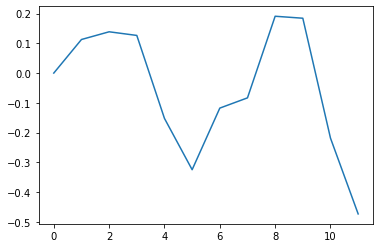

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline
#Cell State 값 확인
print(cx_tmp)
plt.plot(cx_tmp)
plt.show()
#한번의 loop에 Cell State값이 변하고있음을 알 수 있다.

In [75]:
def loss_fn(outputs, labels):
    #다중분류를 위한 대표적인 손실함수
    loss_function = nn.CrossEntropyLoss()
    loss = loss_function(outputs, labels)
    return loss

In [76]:
#sample_target[:, -1]

In [77]:
current_loss = loss_fn(output, sample_target[:, -1])
print(current_loss)

tensor(3.5495, grad_fn=<NllLossBackward0>)


In [78]:
import os
import logging
from sklearn.metrics import accuracy_score

class MetricCalculator():
    """
    loss와 accuracy를 기록하기 위한 도구입니다.
    """
    def __init__(self):
        self.accuracy = 0
        self.loss_accumulated = 0
        self.average_loss = 0
        self.updated_cnt = 0

        self.predicted_labels_holder = []
        self.actual_labels_holder = []

    def update(self, outputs, labels, loss):
        self.updated_cnt += 1

        predicted_labels = outputs.max(1)[1]
        self.predicted_labels_holder.append(predicted_labels)
        self.actual_labels_holder.append(labels)
        self.loss_accumulated += loss


    def calculate_metric(self):

        predicted_labels = torch.cat(self.predicted_labels_holder).cpu().numpy()
        actual_labels = torch.cat(self.actual_labels_holder).cpu().numpy()

        self.accuracy = accuracy_score(actual_labels, predicted_labels)
        self.average_loss = self.loss_accumulated / self.updated_cnt


    def reset(self):
        self.accuracy = 0
        self.loss_accumulated = 0
        self.average_loss = 0
        self.updated_cnt = 0

    def export(self):
        return {
            'loss': self.average_loss,
            'accuracy': self.accuracy,
        }
    
def save_checkpoint(state, is_best, checkpoint, epoch):
    """
    모델을 저장합니다.
    베스트 모델인 경우 카피본을 하나 더 만듭니다.
    """
    filepath = os.path.join(checkpoint, 'e{:02d}.pth.tar'.format(epoch))
    if not os.path.exists(checkpoint):
        print("Checkpoint Directory does not exist! Making directory {}".format(checkpoint))
        os.makedirs(checkpoint)
    else:
        print("Checkpoint Directory exists!")
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(checkpoint, 'best.pth.tar'))


def load_checkpoint(checkpoint, model, optimizer=None):
    """
    저장된 모델 파라미터를 불러와 업데이트합니다.
    """
    if not os.path.exists(checkpoint):
        raise ("File doesn't exist {}".format(checkpoint))
    checkpoint = torch.load(checkpoint)
    model.load_state_dict(checkpoint['state_dict'])

    if optimizer:
        optimizer.load_state_dict(checkpoint['optim_dict'])

    return checkpoint
  
def save_dict_to_json(d, json_path):
    """
    dictionary를 json 파일로 저장한다.
    """
    with open(json_path, 'w') as f:
        # We need to convert the values to float for json (it doesn't accept np.array, np.float, )
        d = {k: float(v) for k, v in d.items()}
        json.dump(d, f, indent=4)

In [79]:
#LSTM 모델을 통해 이름, 성별,국가 데이터를 학습시킵니다.
def train(model, optimizer, loss_fn, data_iterator, num_steps):  
    metric_watcher = MetricCalculator()

    model.train()


    for ix, batch in enumerate(data_iterator):
        inputs = batch.babyname[:, :-1].to(device)
        targets = batch.babyname[:, 1:].to(device)
        sex = batch.sex.float().to(device)
        origin = batch.origin.float().to(device)

        hidden = model.init_hidden(inputs.size(0))

        loss = 0.0

        for step in range(inputs.size(1)):
            outputs, hidden = model.forward(origin, sex, inputs[:, step], hidden)
            current_loss = loss_fn(outputs, targets[:, step])

            metric_watcher.update(outputs, targets[:, step], current_loss)
            loss += current_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    metric_watcher.calculate_metric()
    metrics_string = "loss: {:05.3f}, acc: {:05.3f}".format(
        metric_watcher.average_loss,
        metric_watcher.accuracy
    )
    print("- Train metrics: " + metrics_string)

In [80]:
#loss 값을 담기 위한 list
loss_list=[ ]

def evaluate(model, loss_fn, data_iterator):  
    metric_watcher = MetricCalculator()

    # 모델에 적합시킨다.
    model.eval()

    for ix, batch in enumerate(data_iterator):
        inputs = batch.babyname[:, :-1].to(device)
        targets = batch.babyname[:, 1:].to(device)
        sex = batch.sex.float().to(device)
        origin = batch.origin.float().to(device)

        hidden = model.init_hidden(inputs.size(0))

        loss = 0.0
        
        for step in range(inputs.size(1)):
            outputs, hidden = model.forward(origin, sex, inputs[:, step], hidden)
            current_loss = loss_fn(outputs, targets[:, step])

            metric_watcher.update(outputs, targets[:, step], current_loss)
            loss += current_loss
    metric_watcher.calculate_metric()
    
    metric_watcher.calculate_metric()
    metrics_string = "loss: {:05.3f}, acc: {:05.3f}".format(
        metric_watcher.average_loss,
        metric_watcher.accuracy
    )
    loss_list.append(metric_watcher.average_loss)
    print("- Eval metrics: " + metrics_string)
    return metric_watcher.export()

In [81]:
def train_and_evaluate(model, train_data_iter, val_data_iter, optimizer, loss_fn, model_dir, num_epochs, restore_file=None):
  

    if restore_file is not None:
        restore_path = os.path.join(args.model_dir, args.restore_file + '.pth.tar')
        print("Restoring parameters from {}".format(restore_path))
        load_checkpoint(restore_path, model, optimizer)


    best_val_acc = 0.0

    for epoch in range(num_epochs):

        print("Epoch {}/{}".format(epoch + 1, num_epochs))

        # compute number of batches in one epoch
        num_steps = len(train_data_iter.dataset.examples) // batch_size + 1
        train(model, optimizer, loss_fn, train_data_iter, num_steps)

        val_metrics = evaluate(model, loss_fn, train_data_iter)
        val_acc = val_metrics['accuracy']
        is_best = val_acc > best_val_acc

        # Save weights
        save_checkpoint({'epoch': epoch+1,
                               'state_dict': model.state_dict(),
                               'optim_dict': optimizer.state_dict()},
                              is_best=is_best,
                              checkpoint=model_dir,
                              epoch=epoch+1)

        if is_best:
            print("-- Found new best accuracy")
            best_val_acc = val_acc

            best_json_path = os.path.join(model_dir, "metrics_val_best_weights.json")
            save_dict_to_json(val_metrics, best_json_path)

In [82]:
import torch.optim as optim
import shutil
import json
# hyper parameters
learning_rate = 0.001
weight_decay = 0.001
model_dir = "saved"
#노트북 Ram 한계로 인하여 epoch는 3이 최대였습니다.
num_epochs = 3

train_iter = data_loader.train_iter
val_iter = data_loader.val_iter

# 모델
model = Net(vocab_size=35, embedding_dim=100,
                 nb_sex=2, nb_origin=52,
                 lstm_nb_layers=1, lstm_hidden_dim=200,
                fc_out=300, dropout_p=0.5, 
           ).to(device)

# 최적화 알고리즘
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 손실함수
loss_fn = loss_fn

# 학습 및 평가
print("-- start training for {} epoch(s)".format(num_epochs))
train_and_evaluate(model, train_iter, val_iter, optimizer, loss_fn, model_dir, num_epochs)

-- start training for 3 epoch(s)
Epoch 1/3


D:\Anaconda\lib\site-packages\torchtext\legacy\data\field.py:353: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


- Train metrics: loss: 1.611, acc: 0.503


D:\Anaconda\lib\site-packages\torchtext\legacy\data\field.py:353: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


- Eval metrics: loss: 1.500, acc: 0.528
Checkpoint Directory exists!
-- Found new best accuracy
Epoch 2/3


D:\Anaconda\lib\site-packages\torchtext\legacy\data\field.py:353: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


- Train metrics: loss: 1.486, acc: 0.537


D:\Anaconda\lib\site-packages\torchtext\legacy\data\field.py:353: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


- Eval metrics: loss: 1.420, acc: 0.553
Checkpoint Directory exists!
-- Found new best accuracy
Epoch 3/3


D:\Anaconda\lib\site-packages\torchtext\legacy\data\field.py:353: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


- Train metrics: loss: 1.440, acc: 0.550


D:\Anaconda\lib\site-packages\torchtext\legacy\data\field.py:353: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


- Eval metrics: loss: 1.389, acc: 0.559
Checkpoint Directory exists!
-- Found new best accuracy


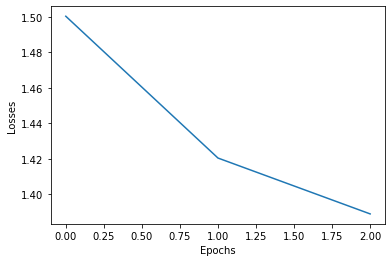

In [96]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#print(loss_list)
#stack 메소드를 통해 list안 각각의 토치원소들을 하나의 토치리스트로 변환
loss=torch.stack(loss_list)
#print(loss)
loss_l=loss.tolist()
#print(loss_l)
#epoch에 따른 loss값을 그래프로 나타냄
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.plot(loss_l)

In [84]:
best_model_path = "saved/best.pth.tar"

checkpoint = load_checkpoint(best_model_path, model)

In [85]:
def sample(data_loader, net, prime, sex, origin):
    """
    문화권, 성별과 시작 글자묶음을 입력받아
    다음 글자들의 확률을 리턴한다.
    """
    origin_tensor = data_loader.ORIGIN.process([origin]).float().to(device)
    sex_tensor = data_loader.SEX.process([sex]).float().to(device)

    prime = prime.lower()
    prime_tensor = data_loader.BABYNAME.process([prime])[:, :-1].to(device)
    bsz, prime_tensor_length = prime_tensor.size()

    # 인풋을 모델에 넣어 출력합니다.
    net.eval()
    with torch.no_grad():
        # batch_size = 1
        hidden = net.init_hidden(1)

        for step in range(prime_tensor_length):
            with torch.no_grad():
                outputs, hidden = net(origin_tensor, sex_tensor, prime_tensor[:, step], hidden)
            probabilities = F.softmax(outputs, 1)

    return probabilities.squeeze()

In [86]:
from collections import OrderedDict
import numpy as np
"""
Beam-Search를 통해 후보 확률 계산
"""
"""
beam-search 부분은 난이도가 어려워 이해를 제대로 하지못해 발표영상에서 삭제하였습니다.
"""
def clean_beam_basket(basket, beam_width):
    _tmp_basket = basket.copy()
    to_remove = sorted(_tmp_basket.items(), key=lambda x: x[1], reverse=True)[beam_width:]
    for item in to_remove:
        _tmp_basket.pop(item[0])

    return _tmp_basket

def beam_search(data_loader, net, beam_width, alpha, prime, sex, origin):
    # print("Sampling a {} {} name beginning with {}..".format(origin, sex, prime))

    beam_basket = OrderedDict()
    beam_basket[prime] = 0.0

    counter = 0
    
    while True:
        counter += 1

        # 바스켓을 청소합니다.
        beam_basket = clean_beam_basket(beam_basket, beam_width)

        # 만약 바스켓에 모든 아이템이 <eos>가 있으면 루프를 멈춘다.
        eos_cnt = 0
        for k in beam_basket.keys():
            if "<eos>" in k:
                eos_cnt += 1
        if eos_cnt == beam_width:
            # print("all items have <eos>")
            break
        new_entries = {}
        to_remove = []
        for k in beam_basket.keys():
            if "<eos>" not in k:
                probabilities = sample(data_loader, net, prime=k, sex=sex, origin=origin)
                for ix, prob in enumerate(probabilities):
                    new_k = k + data_loader.BABYNAME.vocab.itos[ix]
                    added_probability = beam_basket[k] + torch.log(prob).item()
                    len_k = len(k.replace("<eos>", ""))
                    normalized_probability = (1 / (len(k) ** alpha)) * added_probability
                    new_entries[new_k] = normalized_probability
                to_remove.append(k)
    
        # 그리고 기존 key를 beam_basket에서 지운다.
        for k in to_remove:
            beam_basket.pop(k)

        # 새로운 키를 바스켓에 채워넣는다.
        for k, v in new_entries.items():
            beam_basket[k] = v

    final_list = []
    for k, v in beam_basket.items():
        refined_k = k.replace("<eos>", "").capitalize()
        final_list.append(refined_k)
        final_prob = np.exp(v)

    return final_list


In [87]:
#최종 이름 출력함수
def final_names(data_loader, model_dir, prime, sex, origin, beam_width=5, alpha=0.7):
    model = Net(vocab_size=35, embedding_dim=100,
                 nb_sex=2, nb_origin=52,
                 lstm_nb_layers=1, lstm_hidden_dim=200,
                fc_out=300, dropout_p=0.5, 
           ).to(device)
    
    weight_path = os.path.join(model_dir, "best.pth.tar")
    checkpoint = load_checkpoint(weight_path, model)

    final_list = beam_search(data_loader, model, prime=prime, sex=sex, origin=origin, beam_width=beam_width, alpha=alpha)
   
    return final_list

In [88]:
#final_names(data_loader, "saved", "Ma", "girl", "British")

In [89]:
#final_names(data_loader, "saved", "Ma", "girl", "Japanese")

In [90]:
final_names(data_loader, "saved", "hye", "boy", "Spanish")

D:\Anaconda\lib\site-packages\torchtext\legacy\data\field.py:353: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['Hyelon', 'Hyerin', 'Hyeron', 'Hyerino', 'Hyemino']

In [91]:
#스페인과 비교하여 한국의 작명 스타일이 드러남.
final_names(data_loader, "saved", "hye", "girl", "Korea")

['Hyean', 'Hyein', 'Hyeon', 'Hyeun', 'Hyeeun']

In [92]:
final_names(data_loader, "saved", "yu", "girl", "Japanese")

['Yumi', 'Yuko', 'Yushi', 'Yumika', 'Yumiko']

In [93]:
final_names(data_loader, "saved", "yu", "girl", "Korea")

['Yun', 'Yunne', 'Yunhi', 'Yumin', 'Yunney']

In [94]:
final_names(data_loader, "saved", "yu", "boy", "American")

['Yulan', 'Yusty', 'Yuland', 'Yustin', 'Yushan']